In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

c:\Users\20236095\disconet\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


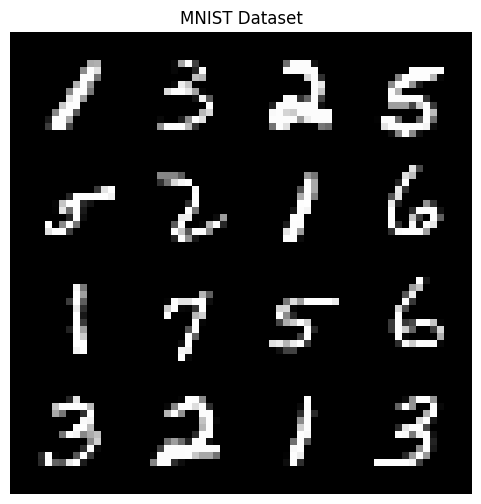

In [44]:
def mnist_dataloader(batch_size=128):
    '''
    Create a DataLoader for the MNIST dataset.
    Args:
        batch_size: int: The batch size to use.
    Returns:
        DataLoader: The DataLoader for the MNIST dataset.
    '''
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((14, 14), interpolation=0),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.Lambda(lambda x: x.view(-1))
    ])
    dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


def plot_dataset(X, verbose=True, **kwargs):
    '''
    Plot a 2D dataset.
    Args:
        X: torch.Tensor: The dataset to plot.
        bins: int: The number of bins to use for the histogram.
        ax: plt.Axes: The axes to plot on. If None, the current axes will be used.
        verbose: bool: Whether to show the axis labels.
        **kwargs: dict: Additional keyword arguments to pass to `ax.set`.
    '''
    # reshape the data to 14x14 images
    X = X.view(-1, 14, 14)
    # get 16 samples from the batch
    X = X[:16].unsqueeze(1)
    # make a grid of the images
    grid = make_grid(X, nrow=4, normalize=True)
    # plot the images
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.title(kwargs.get('title', ''))
    plt.show()


# Create the smiley face dataset and plot it.
dataset = mnist_dataloader()
X, _ = next(iter(dataset))
fig = plt.figure(figsize=(6, 6))
plot_dataset(X, title='MNIST Dataset')

In [45]:
class Block(nn.Module):
    def __init__(self, in_features, out_features, normalize=False):
        '''
        Create a block of an MLP.
        Args:
            in_features: int: The number of input features.
            out_features: int: The number of output features.
            normalize: bool: Whether to apply batch normalization.
        '''
        super().__init__()
        layers = [nn.Linear(in_features, out_features)]
        if normalize:
            layers.append(nn.BatchNorm1d(out_features, 0.8))
        layers.append(nn.ReLU(inplace=True))
        self.block = nn.Sequential(*layers)

    def forward(self, X):
        '''
        Forward pass of the model.
        Args:
            X: torch.Tensor: The input features.
        '''
        return self.block(X)

class Encoder(nn.Module):
    def __init__(self, image_size=14, latent_dim=8):
        '''
        Create an MLP to generate samples from a latent space.
        Args:
            n_features: int: The number of input and output features.
            latent_dim: int: The dimensionality of the latent space.
        '''
        super().__init__()

        
        self.model = nn.Sequential(
            Block(image_size*image_size, 32, normalize=False),
            Block(32, 64),
            Block(64, 128),
        )


    def forward(self, X):
        '''
        Forward pass of the model.
        Args:
            X: torch.Tensor: The input features.
        '''
        X = self.model(X)
        return X
    
class Decoder(nn.Module):
    def __init__(self, image_size=14, latent_dim=16):
        '''
        Create an MLP to generate samples from a latent space.
        Args:
            n_features: int: The number of input and output features.
            latent_dim: int: The dimensionality of the latent space.
        '''
        super().__init__()

        self.model = nn.Sequential(
            Block(latent_dim, 128),
            Block(128, 64),
            Block(64, 32),
            nn.Linear(32, image_size*image_size),
            nn.Tanh()
        )

    def forward(self, X):
        '''
        Forward pass of the model.
        Args:
            X: torch.Tensor: The input features.
        '''
        X = self.model(X)
        return X
    
class VariationalAutoEncoder(nn.Module):
    def __init__(self, image_size=14, latent_dim=8):
        '''
        Create a VAE.
        Args:
            image_size: int: The size of the images.
            latent_dim: int: The dimensionality of the latent space.
        '''
        super().__init__()
        self.encoder = Encoder(image_size, latent_dim)
        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)
        self.decoder = Decoder(image_size, latent_dim)
        self.latent_dim = latent_dim

    def forward(self, X):
        '''
        Forward pass of the model.
        Args:
            X: torch.Tensor: The input features.
        '''
        X = self.encoder(X)
        mu = self.mu(X)
        logvar = self.logvar(X)
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        X = mu + eps*std
        X = self.decoder(X)
        return X, mu, logvar

In [46]:
def kl_loss(mu, logvar):
    '''
    Compute the KL divergence loss.
    Args:
        mu: torch.Tensor: The mean of the latent space.
        logvar: torch.Tensor: The log variance of the latent space.
    Returns:
        torch.Tensor: The KL divergence loss.
    '''
    return (0.5 * torch.sum(torch.exp(logvar) + mu ** 2 - 1 - logvar, dim = 1)).mean()

def vae_loss(X, X_hat, mu, logvar, kl_weight=0.01):
    '''
    Compute the VAE loss.
    Args:
        X: torch.Tensor: The input features.
        X_hat: torch.Tensor: The reconstructed features.
        mu: torch.Tensor: The mean of the latent space.
        logvar: torch.Tensor: The log variance of the latent space.
    Returns:
        torch.Tensor: The VAE loss.
    '''
    return nn.MSELoss()(X, X_hat) + kl_weight*kl_loss(mu, logvar)

@torch.no_grad()
def sample_vae(vae, n_samples=16):
    '''
    Sample from a VAE.
    Args:
        vae: VariationalAutoEncoder: The VAE to sample from.
        n_samples: int: The number of samples to generate.
    Returns:
        torch.Tensor: The generated samples.
    '''
    vae.eval()
    z = torch.randn(n_samples, vae.latent_dim)
    samples = vae.decoder(z)
    return samples

def train_vae(vae, dataloader, epochs=10, lr=0.001):
    '''
    Train a VAE.
    Args:
        vae: VariationalAutoEncoder: The VAE to train.
        dataloader: DataLoader: The DataLoader for the dataset.
        epochs: int: The number of epochs to train for.
        lr: float: The learning rate to use.
    '''
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
    for epoch in trange(epochs):
        for X, _ in dataloader:
            optimizer.zero_grad()
            X_hat, mu, logvar = vae(X)
            loss = vae_loss(X, X_hat, mu, logvar, kl_weight=0.01)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Create the VAE and train it.
vae = VariationalAutoEncoder(latent_dim=16)
train_vae(vae, dataset)

 10%|█         | 1/10 [00:11<01:43, 11.55s/it]

Epoch 1/10, Loss: 0.26030924916267395


 20%|██        | 2/10 [00:22<01:28, 11.11s/it]

Epoch 2/10, Loss: 0.24973885715007782


 30%|███       | 3/10 [00:33<01:17, 11.00s/it]

Epoch 3/10, Loss: 0.2564866244792938


 40%|████      | 4/10 [00:44<01:05, 11.00s/it]

Epoch 4/10, Loss: 0.2381441444158554


 50%|█████     | 5/10 [00:55<00:54, 10.98s/it]

Epoch 5/10, Loss: 0.2436450719833374


 60%|██████    | 6/10 [01:06<00:44, 11.09s/it]

Epoch 6/10, Loss: 0.2306874841451645


 70%|███████   | 7/10 [01:17<00:33, 11.12s/it]

Epoch 7/10, Loss: 0.21427148580551147


 80%|████████  | 8/10 [01:28<00:22, 11.09s/it]

Epoch 8/10, Loss: 0.20608776807785034


 90%|█████████ | 9/10 [01:39<00:11, 11.12s/it]

Epoch 9/10, Loss: 0.23343530297279358


100%|██████████| 10/10 [01:50<00:00, 11.09s/it]

Epoch 10/10, Loss: 0.21771913766860962


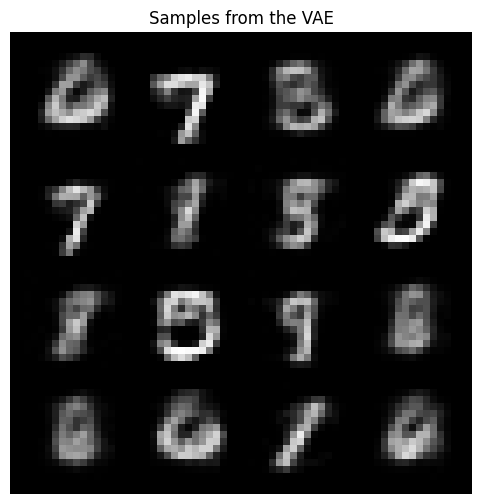

: 

In [47]:
samples = sample_vae(vae)
fig = plt.figure(figsize=(6, 6))
plot_dataset(samples, title='Samples from the VAE')